### Data generator

For selected font, script will generate each of above character (a-z, A-Z, 0-9) at nine different position to move text by one pixel in right-left and top-bottom direction. 

#### NOTE: If you want generate some new data use kernel == python2, because ttfquery can cause problems at python3
Also you can use generated images from Synthetic_dataset

#### Imports

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import ttfquery.findsystem 
import string
import ntpath
import numpy as np
import os
import glob

### Generator

Input params:

    fontSize
    imgSize
    position
    font_list - list of fonts which will be used

In [ ]:
#parameters of font and picture
fontSize = 20
imgSize = (28,28)
position = (0,0)

#fonts which will be used
fonts_list = ['Arial', 'Verdana', 'Comic_Sans_MS', 'Courier_New', 'Times_New_Roman', 'Impact', 'Georgia', 'Trebuc', \
             'Andalemo', 'Lato-Regular']
fonts_list.sort()
total_fonts = len(fonts_list)

#all images will be stored in 'Synthetic_dataset' directory under current directory
dataset_path = os.path.join (os.getcwd(), 'Synthetic_dataset')
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

#creating character list
#it can contains lower case chars, upper case chars and digits
fhandle = open('Fonts_list.txt', 'r')
lower_case_list = list(string.ascii_lowercase)
upper_case_list = list(string.ascii_uppercase)
digits = range(0,10)
digits_list=[str(i) for i in digits]
all_char_list = lower_case_list + upper_case_list + digits_list

#path to ubuntu fonts
#all_fonts = glob.glob("/usr/share/fonts/truetype/msttcorefonts/*.ttf")
all_fonts = ttfquery.findsystem.findFonts()
f_flag = np.zeros(total_fonts)

for sys_font in all_fonts:
    font_file = ntpath.basename(sys_font)
    font_file = font_file.rsplit('.')
    font_file = font_file[0]
    f_idx = 0
    for font in fonts_list: #use fonts from list
        f_lower = font.lower()
        s_lower = sys_font.lower()
        #check desired font 
        #use only regular style
        if f_lower in s_lower and 'bold' not in s_lower and 'italic' not in s_lower:
            #if commented, data will contain all styles of each font
            fonts_list.remove(font)
            path = sys_font
            font = ImageFont.truetype(path, fontSize)
            f_flag[f_idx] = 1
            for ch in all_char_list:
                image = Image.new("RGB", imgSize, (255,255,255))
                draw = ImageDraw.Draw(image)
                pos_x = 0
                pos_y = 0
                pos_idx=0
                for y in [pos_y-1, pos_y, pos_y+1]:
                    for x in [pos_x-1, pos_x, pos_x+1]:
                        position = (x,y)
                        draw.text(position, ch, (0,0,0), font=font)
                        ##without this flag, it creates 'Calibri_a.jpg' even for 'Calibri_A.jpg'
                        ##which overwrites lowercase images
                        l_u_d_flag = "u"
                        if ch.islower():
                            l_u_d_flag = "l"
                        elif ch.isdigit():
                            l_u_d_flag = "d"
                        file_name = str(pos_idx) + '_' + font_file + '_' + l_u_d_flag + '_' + ch + '.jpg'
                        file_name = os.path.join(dataset_path,file_name)
                        image.save(file_name)
                        pos_idx = pos_idx + 1
        f_idx = f_idx + 1

### Data preparation

Here python3 is recommended

#### Imports

In [1]:
import numpy as np
import keras
import tensorflow as tf
import os
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization 
from keras.layers import Conv2D, MaxPooling1D, ActivityRegularization, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import keras

config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

### Read data

In [3]:
fonts_list = ['Arial', 'Verdana', 'Comic_Sans_MS', 'Courier_New', 'Times_New_Roman', 'Impact', 'Georgia', 'Trebuc', \
             'Andalemo', 'Lato-Regular']
fonts_list.sort()

dirName = '/home/dmitrii-saltovskii/dima/Synthetic_dataset/'
pics = os.listdir(dirName)
imgGen = ImageDataGenerator()
fullnames = []
xnames = []

def data_read(postion='0'):
    """
    position is pixel from char starts
    """
    y = []
    X = []
    for name in pics:
        if name[0] == postion: # for only 1 usage of each font with "0" position
            for i in range(len(fonts_list)):
                #creating labels for fonts
                font_i_lower = fonts_list[i].lower()
                name_lower = name.lower()
                if font_i_lower in name_lower:
                    y_cur = i
                    y.append(y_cur)
                    fullname = os.path.join(dirName,name)
                    if os.path.isfile(fullname):
                        fullnames.append(fullname)
                    #loading picture and converting to array
                    img = load_img(fullname, color_mode='grayscale')
                    #imgGen.standardize(img)
                    x = img_to_array(img)
                    X.append(x)
                    xnames.append(name)

    y = np.asarray(y)
    X = np.asarray(X)
    
    return X, y
X, y = data_read(postion='0')

#### Split data to train, validation and test
    Train data is 70% of images
    Validation data is 15% 
    Test data is 15%
    
Also, its not necessary to create validation set, keras can create it from train data, but here it was done

In [4]:
y_oh = keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)
print('train_shape', X_train.shape, '\nval_shape', X_val.shape, '\ntest_shape', X_test.shape)

train_shape (434, 28, 28, 1) 
val_shape (93, 28, 28, 1) 
test_shape (93, 28, 28, 1)


### Model creating

In [47]:
def create_model(params):
    """
    params -- dict of hyperparamets which will be tuned
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=IMG_SIZE))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(params['dropout_1']))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(params['dropout_2']))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

### Datagen for train and valdation

### Case 1

There is simple case:

We have some images with different fonts.
Assumpt that all chars have equal positions at image (in train, validation and test data).

## Tuning hyperparameters
#### First iteration
The aim of this iteration is reduce parameters bounds.
Parameters will be tuning:

    batch_size -- [10, 16, 32]
    dropout_1 -- random in [0,0.5]
    dropout_2 -- random in [0.5,1]
    
Also, we can add number of dense units, but for faster computing we fixed it.

Parameters which will be tuned

At first iteration we calculate $ F_\beta = (1+\beta^2) \frac{acc_{test} * \frac{acc_{test}}{acc_{train}}}{\beta^2 * acc_{test} + \frac{acc_{test}}{acc_{train}}}, $

where $\beta = 0.5,$

because we preffer non overfitted model.


In [31]:
batch_sizes = [10,16,32] #grid search
epochs = 20
IMG_SIZE = X.shape[1:]
# dropout random gen in [0,1]
drop_1_b = [0,0.5]
drop_2_b = [0.5,0.7]
unit_b = [24,64]
num_experiments = 3 #for each batch

### Tuning process

In [48]:
np.random.seed(0) 
res = []
weights = []
beta = 0.5
best_f1_score = 0.0

def fb_score(a,b,beta=2):
    tmp = a/b
    if tmp>1.0:
        tmp=b
    return (1.+beta**2)*(a*tmp)/(beta**2 * a+tmp)

for batch in batch_sizes[::-1]:
    for num in range(num_experiments):
        print(num)    
        params = dict(dropout_1=(drop_1_b[1]-drop_1_b[0])*np.random.rand()+drop_1_b[0],\
                      dropout_2=(drop_2_b[1]-drop_2_b[0])*np.random.rand()+drop_2_b[0])
        print(params)
        model = create_model(params)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch,\
        epochs=epochs, shuffle=True)
        score = model.evaluate(X_test, y_test, batch_size=batch)
        params['batch']=batch
        params['score']=score
        params['score_train']=[history.history['loss'][-1], history.history['acc'][-1]]
        params['score_val']=[history.history['val_loss'][-1], history.history['val_acc'][-1]]
        params['f1_score'] = fb_score(params['score_val'][1], params['score_train'][1], beta=beta)
        if params['f1_score'] > best_f1_score:
            history_best = history
            best_f1_score = params['f1_score']
            np.savetxt('acc.txt', history.history['acc'])
            np.savetxt('loss.txt', history.history['loss'])
            np.savetxt('val_acc.txt', history.history['val_acc'])
            np.savetxt('val_loss.txt', history.history['val_loss'])
            model.save('model_1_'+str(batch)+'_'+str(num))
            print('cur_best_score = ', score, ' cur_best_f1_score = ', best_f1_score)
        res.append(params)
        print('train score', params['score_train'], '\n', 'val score', params['score_val'],'\n', 'test score', score)         

0
{'dropout_1': 0.2744067519636624, 'dropout_2': 0.6430378732744839}
Train on 434 samples, validate on 93 samples
Epoch 1/20
434/434 [==============================] - 5s 12ms/step - loss: 2.5965 - acc: 0.1475 - val_loss: 1.7817 - val_acc: 0.3656
Epoch 2/20
434/434 [==============================] - 0s 709us/step - loss: 1.9748 - acc: 0.3226 - val_loss: 1.4457 - val_acc: 0.6022
Epoch 3/20
434/434 [==============================] - 0s 706us/step - loss: 1.6651 - acc: 0.4101 - val_loss: 1.3221 - val_acc: 0.6559
Epoch 4/20
434/434 [==============================] - 0s 681us/step - loss: 1.4916 - acc: 0.4862 - val_loss: 1.2461 - val_acc: 0.6667
Epoch 5/20
434/434 [==============================] - 0s 701us/step - loss: 1.3136 - acc: 0.5760 - val_loss: 1.1759 - val_acc: 0.7097
Epoch 6/20
434/434 [==============================] - 0s 737us/step - loss: 1.2888 - acc: 0.5668 - val_loss: 1.1186 - val_acc: 0.7204
Epoch 7/20
434/434 [==============================] - 0s 785us/step - loss: 1.1690 

Epoch 15/20
434/434 [==============================] - 0s 609us/step - loss: 0.5841 - acc: 0.8710 - val_loss: 0.6687 - val_acc: 0.8495
Epoch 16/20
434/434 [==============================] - 0s 609us/step - loss: 0.5272 - acc: 0.8963 - val_loss: 0.6203 - val_acc: 0.8710
Epoch 17/20
434/434 [==============================] - 0s 703us/step - loss: 0.5194 - acc: 0.8894 - val_loss: 0.6036 - val_acc: 0.8495
Epoch 18/20
434/434 [==============================] - 0s 724us/step - loss: 0.4905 - acc: 0.8940 - val_loss: 0.5888 - val_acc: 0.8602
Epoch 19/20
434/434 [==============================] - 0s 755us/step - loss: 0.4584 - acc: 0.9032 - val_loss: 0.5576 - val_acc: 0.8495
Epoch 20/20
93/93 [==============================] - 0s 285us/step
train score [0.4194058525260143, 0.9193548387096774] 
 val score [0.5478866260538819, 0.8709677432173042] 
 test score [0.44055630346780184, 0.8602150492770697]
0
{'dropout_1': 0.02236874783291465, 'dropout_2': 0.6575493177160645}
Train on 434 samples, valid

434/434 [==============================] - 0s 1ms/step - loss: 1.2372 - acc: 0.6060 - val_loss: 1.0626 - val_acc: 0.7419
Epoch 10/20
434/434 [==============================] - 0s 1ms/step - loss: 1.2125 - acc: 0.6313 - val_loss: 0.9959 - val_acc: 0.7527
Epoch 11/20
434/434 [==============================] - 0s 1ms/step - loss: 1.1588 - acc: 0.6336 - val_loss: 0.9842 - val_acc: 0.7097
Epoch 12/20
434/434 [==============================] - 0s 938us/step - loss: 1.1080 - acc: 0.6521 - val_loss: 0.9408 - val_acc: 0.7097
Epoch 13/20
434/434 [==============================] - 0s 1ms/step - loss: 1.1118 - acc: 0.6544 - val_loss: 0.9067 - val_acc: 0.7527
Epoch 14/20
434/434 [==============================] - 0s 988us/step - loss: 1.0452 - acc: 0.6935 - val_loss: 0.8627 - val_acc: 0.7634
Epoch 15/20
434/434 [==============================] - 0s 889us/step - loss: 1.0335 - acc: 0.6959 - val_loss: 0.8336 - val_acc: 0.7742
Epoch 16/20
434/434 [==============================] - 0s 1ms/step - loss: 

434/434 [==============================] - 1s 1ms/step - loss: 1.8965 - acc: 0.3226 - val_loss: 1.4456 - val_acc: 0.6237
Epoch 3/20
434/434 [==============================] - 1s 1ms/step - loss: 1.6023 - acc: 0.4608 - val_loss: 1.2989 - val_acc: 0.6559
Epoch 4/20
434/434 [==============================] - 1s 1ms/step - loss: 1.4071 - acc: 0.5092 - val_loss: 1.2058 - val_acc: 0.6559
Epoch 5/20
434/434 [==============================] - 1s 1ms/step - loss: 1.2455 - acc: 0.6175 - val_loss: 1.0898 - val_acc: 0.6452
Epoch 6/20
434/434 [==============================] - 1s 1ms/step - loss: 1.1134 - acc: 0.6705 - val_loss: 0.9658 - val_acc: 0.7204
Epoch 7/20
434/434 [==============================] - 1s 1ms/step - loss: 1.0362 - acc: 0.6889 - val_loss: 0.8667 - val_acc: 0.7527
Epoch 8/20
434/434 [==============================] - 1s 1ms/step - loss: 0.9869 - acc: 0.6820 - val_loss: 0.8089 - val_acc: 0.7849
Epoch 9/20
434/434 [==============================] - 1s 2ms/step - loss: 0.9226 - acc:

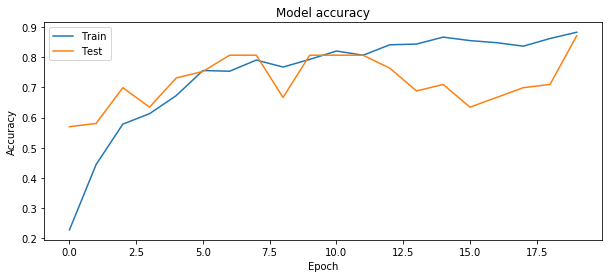

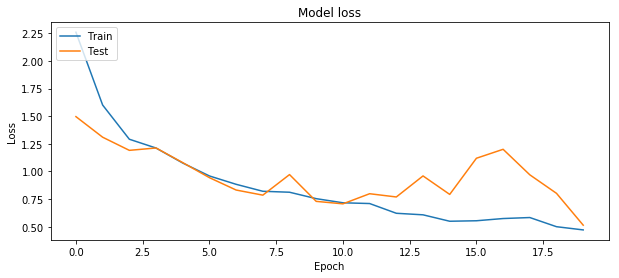

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,4))
plt.plot(history_best.history['acc'])
plt.plot(history_best.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,4))
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#### Second iteration

### Select top N models and do new tuning

Choose N top models for parameters bounds reducing

In [50]:
N = 3 
scorelist = [res_i['f1_score'] for res_i in res]
scorelist_sorted = sorted(scorelist, reverse=True)
toplist_ind = [scorelist.index(scorelist_sorted[i]) for i in range(N)]
toplist = [res[i] for i in toplist_ind]
params_full = dict(dropout_1=[], dropout_2=[], batch=[])
for key in params_full.keys():
    for i in range(N):
        params_full[key].append(toplist[i][key])
print(params_full)        
#creating new params bounds
drop_1_b = [np.min(params_full['dropout_1']), np.max(params_full['dropout_1'])]
drop_2_b = [np.min(params_full['dropout_2']), np.max(params_full['dropout_2'])]
batch_sizes = np.unique(params_full['batch'])
print(batch_sizes)
file = open('history.txt', mode='a') #here will be model history
#run tunning
num_experiments = 5 #for each batch
res = []
weights = []
best_f1_score = 0.0
beta = 0.5

for batch in batch_sizes:
    for num in range(num_experiments):
        print(num)    
        params_top = dict(dropout_1=(drop_1_b[1]-drop_1_b[0])*np.random.rand()+drop_1_b[0],\
                          dropout_2=(drop_2_b[1]-drop_2_b[0])*np.random.rand()+drop_2_b[0])
        model = create_model(params_top)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch, epochs=epochs, shuffle=True)
        score = model.evaluate(X_test, y_test, batch_size=batch)
        params_top['batch']=batch
        params_top['score']=score
        params_top['score_train']=[history.history['loss'][-1], history.history['acc'][-1]]
        params_top['score_val']=[history.history['val_loss'][-1], history.history['val_acc'][-1]]
        params_top['f1_score'] = fb_score(params_top['score_val'][1], params_top['score_train'][1], beta=beta)

        if params_top['f1_score'] > best_f1_score:
            history_best_top = history
            best_f1_score = params_top['f1_score']
            np.savetxt('acc_top.txt', history.history['acc'])
            np.savetxt('loss_top.txt', history.history['loss'])
            np.savetxt('val_acc_top.txt', history.history['val_acc'])
            np.savetxt('val_loss_top.txt', history.history['val_loss'])
            model.save('model_topN_'+str(batch)+'_'+str(num))
            print('cur_best_score = ', score, ' cur_best_f1_score = ', best_f1_score)
        res.append(params_top)
        print('train score', params['score_train'], '\n', 'val score', params['score_val'],'\n', 'test score', score) 
        

{'batch': [10, 32, 32], 'dropout_2': [0.664686844083074, 0.557303933158332, 0.5896843915061626], 'dropout_1': [0.02406078724245181, 0.11943773561710436, 0.14148314462222417]}
[10 32]
0
Train on 434 samples, validate on 93 samples
Epoch 1/20
434/434 [==============================] - 6s 14ms/step - loss: 2.1305 - acc: 0.2742 - val_loss: 1.3282 - val_acc: 0.5806
Epoch 2/20
434/434 [==============================] - 1s 2ms/step - loss: 1.4557 - acc: 0.4977 - val_loss: 1.1422 - val_acc: 0.7312
Epoch 3/20
434/434 [==============================] - 1s 1ms/step - loss: 1.2350 - acc: 0.5922 - val_loss: 0.9835 - val_acc: 0.7312
Epoch 4/20
434/434 [==============================] - 1s 1ms/step - loss: 1.0495 - acc: 0.6889 - val_loss: 0.9192 - val_acc: 0.7204
Epoch 5/20
434/434 [==============================] - 1s 2ms/step - loss: 0.9576 - acc: 0.7189 - val_loss: 0.8678 - val_acc: 0.7742
Epoch 6/20
434/434 [==============================] - 1s 1ms/step - loss: 0.8360 - acc: 0.7604 - val_loss: 0.

434/434 [==============================] - 1s 1ms/step - loss: 0.4550 - acc: 0.9009 - val_loss: 0.4517 - val_acc: 0.8817
Epoch 17/20
434/434 [==============================] - 1s 1ms/step - loss: 0.4711 - acc: 0.8848 - val_loss: 0.4488 - val_acc: 0.8602
Epoch 18/20
434/434 [==============================] - 1s 1ms/step - loss: 0.4312 - acc: 0.8986 - val_loss: 0.4362 - val_acc: 0.8710
Epoch 19/20
434/434 [==============================] - 1s 2ms/step - loss: 0.4028 - acc: 0.9124 - val_loss: 0.4043 - val_acc: 0.8925
Epoch 20/20
93/93 [==============================] - 0s 436us/step
cur_best_score =  [0.3728935696104521, 0.8924731118704683]  cur_best_f1_score =  0.89575529169074
train score [0.5243641978584677, 0.8709677364419682] 
 val score [0.5039818773987472, 0.8709677368082026] 
 test score [0.3728935696104521, 0.8924731118704683]
3
Train on 434 samples, validate on 93 samples
Epoch 1/20
434/434 [==============================] - 6s 14ms/step - loss: 2.1990 - acc: 0.2442 - val_loss: 

434/434 [==============================] - 0s 511us/step - loss: 0.8784 - acc: 0.7719 - val_loss: 0.8710 - val_acc: 0.7742
Epoch 11/20
434/434 [==============================] - 0s 543us/step - loss: 0.7977 - acc: 0.7903 - val_loss: 0.8676 - val_acc: 0.7419
Epoch 12/20
434/434 [==============================] - 0s 568us/step - loss: 0.7119 - acc: 0.8433 - val_loss: 0.7703 - val_acc: 0.8280
Epoch 13/20
434/434 [==============================] - 0s 615us/step - loss: 0.6852 - acc: 0.8341 - val_loss: 0.7208 - val_acc: 0.8495
Epoch 14/20
434/434 [==============================] - 0s 587us/step - loss: 0.6172 - acc: 0.8571 - val_loss: 0.6898 - val_acc: 0.8280
Epoch 15/20
434/434 [==============================] - 0s 552us/step - loss: 0.5926 - acc: 0.8779 - val_loss: 0.6634 - val_acc: 0.8387
Epoch 16/20
434/434 [==============================] - 0s 547us/step - loss: 0.5976 - acc: 0.8802 - val_loss: 0.6077 - val_acc: 0.8495
Epoch 17/20
434/434 [==============================] - 0s 623us/ste

434/434 [==============================] - 0s 781us/step - loss: 1.1431 - acc: 0.6498 - val_loss: 1.0702 - val_acc: 0.6989
Epoch 6/20
434/434 [==============================] - 0s 689us/step - loss: 1.0144 - acc: 0.7097 - val_loss: 1.0188 - val_acc: 0.7849
Epoch 7/20
434/434 [==============================] - 0s 608us/step - loss: 0.9577 - acc: 0.7074 - val_loss: 0.9488 - val_acc: 0.7849
Epoch 8/20
434/434 [==============================] - 0s 726us/step - loss: 0.8930 - acc: 0.7512 - val_loss: 0.9439 - val_acc: 0.7419
Epoch 9/20
434/434 [==============================] - 0s 745us/step - loss: 0.8419 - acc: 0.7788 - val_loss: 0.9087 - val_acc: 0.7634
Epoch 10/20
434/434 [==============================] - 0s 729us/step - loss: 0.7724 - acc: 0.8203 - val_loss: 0.8603 - val_acc: 0.7957
Epoch 11/20
434/434 [==============================] - 0s 637us/step - loss: 0.7146 - acc: 0.8203 - val_loss: 0.8360 - val_acc: 0.7849
Epoch 12/20
434/434 [==============================] - 0s 785us/step - 

### Load history for visualization

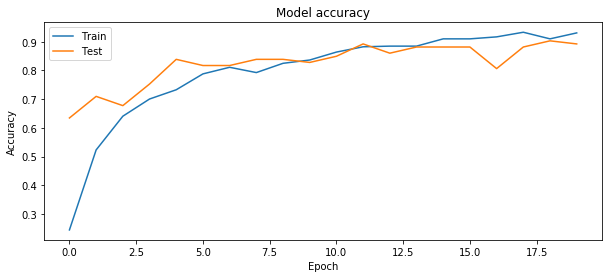

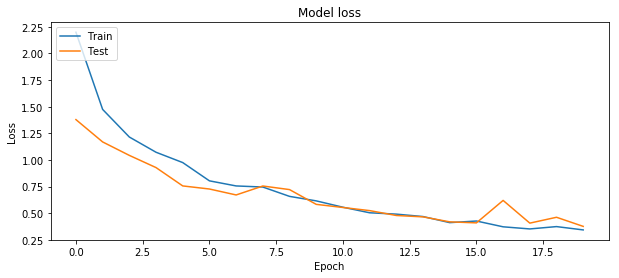

In [51]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,4))
plt.plot(history_best_top.history['acc'])
plt.plot(history_best_top.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,4))
plt.plot(history_best_top.history['loss'])
plt.plot(history_best_top.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
